## Initialise

#### Imports

In [1]:
import os
import joblib
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#### Load data

In [2]:
data_path = os.path.join('datasets', 'nyc education + jobs')

def load_data(filename, path):
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

census_2010 = load_data("nyc_census_2010.csv", data_path)
census_2018 = load_data("nyc_census_2018.csv", data_path)

#### Data cleaning

Drop unrequired columns

In [3]:
census_2010 = census_2010.drop(columns=['year', 'NAME', 'state', 'county', 'tract', 'B08528_010E'])
census_2018 = census_2018.drop(columns=['year', 'NAME', 'state', 'county', 'tract', 'B08528_010E'])

Rename column names

In [4]:
def column_names(dataframe, year):
    year_columns = []
    columns = ['population', 'household_income', 'home_value', 
                        'no_nonh_caucasians', 'no_nonh_blacks/aas', 'no_amerinds_alskns', 'no_nonh_asians',
                        'no_nonh_hawaii_pacific', 'no_nonh_others', 'no_nonh_multi', 'no_hisp_latin',
                        'construction', 'retail', 'information', 'finance', 'edu_health_social',
                        'arts_recreation_accom', 'public_admin', 'armed_forces', 'bachelors', 'male<25_bachelors',
                        'female<25_bachelors']
    year_columns.append('geoid')
    for i in columns:
        year_columns.append(year + '_' + i)
    dataframe.columns = year_columns

column_names(census_2010, '2010')
column_names(census_2018, '2018')

Check information regarding both datasets.
Notable piece of information: 2010 has 4701 entries, whilst 2018 has 4700.

In [5]:
census_2010.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701 entries, 0 to 4700
Data columns (total 23 columns):
geoid                          4701 non-null int64
2010_population                4701 non-null float64
2010_household_income          4701 non-null float64
2010_home_value                4701 non-null float64
2010_no_nonh_caucasians        4701 non-null float64
2010_no_nonh_blacks/aas        4701 non-null float64
2010_no_amerinds_alskns        4701 non-null float64
2010_no_nonh_asians            4701 non-null float64
2010_no_nonh_hawaii_pacific    4701 non-null float64
2010_no_nonh_others            4701 non-null float64
2010_no_nonh_multi             4701 non-null float64
2010_no_hisp_latin             4701 non-null float64
2010_construction              4701 non-null float64
2010_retail                    4701 non-null float64
2010_information               4701 non-null float64
2010_finance                   4701 non-null float64
2010_edu_health_social         4701 non-null fl

In [6]:
census_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4700 entries, 0 to 4699
Data columns (total 23 columns):
geoid                          4700 non-null int64
2018_population                4700 non-null float64
2018_household_income          4700 non-null float64
2018_home_value                4700 non-null float64
2018_no_nonh_caucasians        4700 non-null float64
2018_no_nonh_blacks/aas        4700 non-null float64
2018_no_amerinds_alskns        4700 non-null float64
2018_no_nonh_asians            4700 non-null float64
2018_no_nonh_hawaii_pacific    4700 non-null float64
2018_no_nonh_others            4700 non-null float64
2018_no_nonh_multi             4700 non-null float64
2018_no_hisp_latin             4700 non-null float64
2018_construction              4700 non-null float64
2018_retail                    4700 non-null float64
2018_information               4700 non-null float64
2018_finance                   4700 non-null float64
2018_edu_health_social         4700 non-null fl

Merge both datasets into one dataframe, based on geoid.

In [7]:
census_data = pd.merge(census_2010, census_2018, on='geoid')

In [8]:
census_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4700 entries, 0 to 4699
Data columns (total 45 columns):
geoid                          4700 non-null int64
2010_population                4700 non-null float64
2010_household_income          4700 non-null float64
2010_home_value                4700 non-null float64
2010_no_nonh_caucasians        4700 non-null float64
2010_no_nonh_blacks/aas        4700 non-null float64
2010_no_amerinds_alskns        4700 non-null float64
2010_no_nonh_asians            4700 non-null float64
2010_no_nonh_hawaii_pacific    4700 non-null float64
2010_no_nonh_others            4700 non-null float64
2010_no_nonh_multi             4700 non-null float64
2010_no_hisp_latin             4700 non-null float64
2010_construction              4700 non-null float64
2010_retail                    4700 non-null float64
2010_information               4700 non-null float64
2010_finance                   4700 non-null float64
2010_edu_health_social         4700 non-null fl

#### Data manipulation

Account for inflation in 2018 home values, compared to 2010 home values.
Inflation (CPI) over the 8 year period in the USA: 13.5%

In [9]:
census_data['2018_home_value']

0        710600.0
1       2000001.0
2        466600.0
3        631000.0
4        332800.0
          ...    
4695     161100.0
4696     158100.0
4697     125600.0
4698     141600.0
4699     161200.0
Name: 2018_home_value, Length: 4700, dtype: float64

In [10]:
census_data['2018_home_value'] = census_data['2018_home_value'] * 0.865

In [11]:
census_data['2018_home_value']

0        614669.000
1       1730000.865
2        403609.000
3        545815.000
4        287872.000
           ...     
4695     139351.500
4696     136756.500
4697     108644.000
4698     122484.000
4699     139438.000
Name: 2018_home_value, Length: 4700, dtype: float64

Create column for number of people aged 25+ with bachelors degrees

In [12]:
census_data['2018_>25bachelors'] = census_data['2018_bachelors'] - census_data['2018_male<25_bachelors'] - census_data['2018_female<25_bachelors']
census_data['2010_>25bachelors'] = census_data['2010_bachelors'] - census_data['2010_male<25_bachelors'] - census_data['2010_female<25_bachelors']

Remove corrupted entries with negative values

In [13]:
census_data = census_data[census_data['2010_population'] > 0]
census_data = census_data[census_data['2010_household_income'] > 0]
census_data = census_data[census_data['2010_home_value'] > 0]
census_data = census_data[census_data['2010_>25bachelors'] >= 0]
census_data = census_data[census_data['2018_population'] > 0]
census_data = census_data[census_data['2018_household_income'] > 0]
census_data = census_data[census_data['2018_home_value'] > 0]
census_data = census_data[census_data['2018_>25bachelors'] >= 0]

Proportion of population aged 25+ with bachelors degrees.

In [14]:
census_data['2018_percent_>25bachelors'] = census_data['2018_>25bachelors'] / census_data['2018_population']
census_data['2010_percent_>25bachelors'] = census_data['2010_>25bachelors'] / census_data['2010_population']

Change in the proportion of population with bachelors degrees, from 2010 to 2018.

In [15]:
census_data['change_percent_>25bachelors'] = (census_data['2018_percent_>25bachelors'] - census_data['2010_percent_>25bachelors'])

Percentage change in home value from 2010 to 2018.

In [16]:
census_data['percent_change_home_value'] = 100*(census_data['2018_home_value'] - census_data['2010_home_value']) / census_data['2010_home_value']

In [17]:
census_data['percent_change_home_value']

0      -17.093472
1       72.999914
2      -23.890439
3      -24.276498
4      -21.624830
          ...    
4695   -19.774611
4696   -36.273765
4697   -36.981439
4698   -32.329282
4699   -29.219289
Name: percent_change_home_value, Length: 4370, dtype: float64

Apply test one to the entries, checking which tracts are eligible for gentrification.

In [18]:
census_data['gentrify_elig'] = 0

income_40_percentile = census_data['2010_household_income'].quantile(0.4)
value_40_percentile = census_data['2010_home_value'].quantile(0.4)

census_data.loc[(census_data['2010_household_income'] <= income_40_percentile) & 
               (census_data['2010_home_value'] <= value_40_percentile) &
               (census_data['2010_population'] >= 500), 'gentrify_elig'] = 1

Calculate 66th percentile for increase in proportion of population with bachelors degrees and 66th percentile for percentage change in home value. Remove negative value of percent change because criteria is based on **increases** only.

In [19]:
census_data_copy = census_data.copy()
census_data_copy = census_data_copy[census_data_copy['percent_change_home_value'] >= 0]
census_data_copy = census_data_copy[census_data_copy['change_percent_>25bachelors'] >= 0]

In [20]:
education_66_percentile = census_data_copy['change_percent_>25bachelors'].quantile(0.66)
value_66_percentile = census_data_copy['percent_change_home_value'].quantile(0.66)
education_66_percentile

0.0465370767343592

In [21]:
value_66_percentile

26.491263714533048

Carry on test two: check which tracts have improved based on increase in proportion of people with bachelors degrees and increase in median home value.

In [22]:
census_data['test_two'] = 0

census_data.loc[(census_data['change_percent_>25bachelors'] >= education_66_percentile) & 
               (census_data['percent_change_home_value'] >= value_66_percentile) &
               (census_data['percent_change_home_value'] > 0), 'test_two'] = 1

Check which tracts have gentrified: pass both tests 1 (eligible for gentrification) and 2 (improved)

In [23]:
census_data['gentrified'] = 0

census_data.loc[(census_data['gentrify_elig'] == 1) & 
               (census_data['test_two'] == 1), 'gentrified'] = 1

In [24]:
census_data['gentrified']

0       0
1       0
2       0
3       0
4       0
       ..
4695    0
4696    0
4697    0
4698    0
4699    0
Name: gentrified, Length: 4370, dtype: int64

In [55]:
census_data['gentrified'].value_counts()

0    4357
1      13
Name: gentrified, dtype: int64

13 tracts gentrified

In [26]:
census_data.loc[census_data['gentrified'] == 1]

,geoid,2010_population,2010_household_income,2010_home_value,2010_no_nonh_caucasians,2010_no_nonh_blacks/aas,2010_no_amerinds_alskns,2010_no_nonh_asians,2010_no_nonh_hawaii_pacific,2010_no_nonh_others,...,2018_female<25_bachelors,2018_>25bachelors,2010_>25bachelors,2018_percent_>25bachelors,2010_percent_>25bachelors,change_percent_>25bachelors,percent_change_home_value,gentrify_elig,test_two,gentrified
447,34017007100,2747.0,34438.0,303700.0,797.0,294.0,31.0,752.0,0.0,118.0,...,23.0,702.0,388.0,0.211893,0.141245,0.070648,60.211557,1,1,1
776,34025805600,1680.0,25510.0,205400.0,185.0,692.0,12.0,0.0,0.0,22.0,...,0.0,120.0,0.0,0.048940,0.000000,0.048940,33.624391,1,1,1
1925,36047008800,3007.0,43321.0,276300.0,901.0,7.0,0.0,219.0,0.0,0.0,...,59.0,299.0,174.0,0.113429,0.057865,0.055564,53.151647,1,1,1
1943,36047011900,1635.0,55156.0,382600.0,664.0,190.0,12.0,0.0,0.0,14.0,...,13.0,315.0,235.0,0.228758,0.143731,0.085027,133.161134,1,1,1
2294,36047042900,6010.0,30813.0,184700.0,390.0,499.0,24.0,242.0,0.0,0.0,...,48.0,375.0,71.0,0.070409,0.011814,0.058596,227.407417,1,1,1
2312,36047044700,1880.0,41648.0,281800.0,357.0,67.0,0.0,44.0,0.0,31.0,...,47.0,262.0,83.0,0.110177,0.044149,0.066028,135.710965,1,1,1
2334,36047048200,5709.0,30164.0,317300.0,3973.0,337.0,0.0,863.0,0.0,8.0,...,53.0,669.0,360.0,0.125894,0.063058,0.062836,33.771037,1,1,1
2367,36047051400,7620.0,38977.0,266200.0,636.0,4347.0,0.0,471.0,0.0,0.0,...,0.0,1147.0,343.0,0.144422,0.045013,0.099409,37.776108,1,1,1
2922,36061018400,8434.0,27236.0,372400.0,445.0,2559.0,0.0,394.0,0.0,16.0,...,9.0,707.0,275.0,0.097410,0.032606,0.064804,91.280209,1,1,1
2951,36061021303,6058.0,40512.0,193800.0,672.0,3240.0,12.0,118.0,0.0,128.0,...,31.0,809.0,496.0,0.134811,0.081875,0.052936,92.995872,1,1,1


In [27]:
census_data['gentrify_elig'].value_counts()

0    3528
1     842
Name: gentrify_elig, dtype: int64

842 tracts eligible for gentrification

In [54]:
census_data['test_two'].value_counts()

0    4296
1      74
Name: test_two, dtype: int64

74 tracts have improved

Correlation for gentrification eligibility, improvement and gentrification.

In [29]:
corr_matrix = census_data.corr()
corr_matrix["gentrify_elig"].sort_values(ascending=False)

gentrify_elig                  1.000000
2018_no_hisp_latin             0.338117
2010_no_hisp_latin             0.321773
2010_no_nonh_blacks/aas        0.268569
2018_no_nonh_blacks/aas        0.253479
gentrified                     0.111811
2018_arts_recreation_accom     0.088252
2018_no_amerinds_alskns        0.087745
2010_no_amerinds_alskns        0.054162
2018_no_nonh_others            0.049124
2018_retail                    0.047614
percent_change_home_value      0.046813
2010_arts_recreation_accom     0.043675
2010_no_nonh_others            0.038822
2018_population                0.037102
2018_construction              0.028580
2010_armed_forces              0.027868
2010_population                0.023721
2010_construction              0.010709
2018_no_nonh_hawaii_pacific    0.000167
2010_retail                   -0.000540
2018_armed_forces             -0.003987
test_two                      -0.005658
2010_no_nonh_hawaii_pacific   -0.005709
2010_no_nonh_multi            -0.021541


In [30]:
corr_matrix["gentrified"].sort_values(ascending=False)

gentrified                     1.000000
test_two                       0.416192
gentrify_elig                  0.111811
2018_arts_recreation_accom     0.110051
2010_no_hisp_latin             0.096245
percent_change_home_value      0.080577
change_percent_>25bachelors    0.077471
2018_no_hisp_latin             0.064415
2010_arts_recreation_accom     0.050634
2018_male<25_bachelors         0.047744
2018_no_nonh_multi             0.036408
2010_population                0.033788
2010_female<25_bachelors       0.030862
2018_population                0.027177
2018_information               0.026078
2010_no_nonh_blacks/aas        0.021894
2018_retail                    0.021243
2018_bachelors                 0.021226
2010_no_nonh_multi             0.020232
2018_no_nonh_blacks/aas        0.019449
geoid                          0.016350
2010_edu_health_social         0.015365
2010_construction              0.014860
2018_>25bachelors              0.013472
2018_no_nonh_asians            0.013314


In [31]:
corr_matrix['test_two'].sort_values(ascending=False)

test_two                       1.000000
gentrified                     0.416192
2018_home_value                0.282912
change_percent_>25bachelors    0.234283
2018_information               0.176000
2018_male<25_bachelors         0.175826
2018_percent_>25bachelors      0.149544
percent_change_home_value      0.116408
2010_male<25_bachelors         0.106581
2018_bachelors                 0.104957
2010_female<25_bachelors       0.102613
2010_home_value                0.094324
2018_>25bachelors              0.077132
2018_arts_recreation_accom     0.075793
2018_finance                   0.073509
2018_no_nonh_multi             0.072129
2010_information               0.066402
geoid                          0.057634
2010_arts_recreation_accom     0.053336
2018_female<25_bachelors       0.051724
2018_household_income          0.046870
2010_no_nonh_multi             0.035922
2010_finance                   0.030813
2018_no_nonh_asians            0.019060
2010_no_nonh_blacks/aas        0.015112


In [56]:
census_data.to_csv('test_one__test_two.csv', index=False)

## Random Forest

Predict whether a tract passes test two (sufficient improvement for gentrification)

In [32]:
census_data_x = census_data.copy()
census_data_x = census_data_x.drop(columns=['gentrify_elig', 'geoid', 'test_two', 'gentrified'])
census_data_y = census_data['test_two']
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(census_data_x, census_data_y)
forest_scores = cross_val_score(forest_clf, census_data_x, census_data_y, cv=5)
forest_scores.mean()

0.9945082670818687

In [33]:
census_data_y2 = census_data['gentrified']
forest_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf2.fit(census_data_x, census_data_y2)
forest_scores = cross_val_score(forest_clf2, census_data_x, census_data_y2, cv=5)
forest_scores.mean()

0.9970256922749126

#### Test on data from San Francisco MSA

In [34]:
ca_data_path = os.path.join('datasets', 'CA MSA new')

In [35]:
ca_census_2010 = load_data("ca_census_2010.csv", ca_data_path)
ca_census_2018 = load_data("ca_census_2018.csv", ca_data_path)

In [36]:
ca_census_2010 = ca_census_2010.drop(columns=['year', 'NAME', 'state', 'county', 'tract'])
ca_census_2018 = ca_census_2018.drop(columns=['year', 'NAME', 'state', 'county', 'tract'])

In [37]:
column_names(ca_census_2010, '2010')
column_names(ca_census_2018, '2018')

In [38]:
ca_census_data = pd.merge(ca_census_2010, ca_census_2018, on='geoid')

In [39]:
ca_census_data['2018_home_value'] = ca_census_data['2018_home_value'] * 0.865

ca_census_data['2018_>25bachelors'] = ca_census_data['2018_bachelors'] - ca_census_data['2018_male<25_bachelors'] - ca_census_data['2018_female<25_bachelors']
ca_census_data['2010_>25bachelors'] = ca_census_data['2010_bachelors'] - ca_census_data['2010_male<25_bachelors'] - ca_census_data['2010_female<25_bachelors']

ca_census_data = ca_census_data[ca_census_data['2010_population'] > 0]
ca_census_data = ca_census_data[ca_census_data['2010_household_income'] > 0]
ca_census_data = ca_census_data[ca_census_data['2010_home_value'] > 0]
ca_census_data = ca_census_data[ca_census_data['2010_>25bachelors'] >= 0]
ca_census_data = ca_census_data[ca_census_data['2018_population'] > 0]
ca_census_data = ca_census_data[ca_census_data['2018_household_income'] > 0]
ca_census_data = ca_census_data[ca_census_data['2018_home_value'] > 0]
ca_census_data = ca_census_data[ca_census_data['2018_>25bachelors'] >= 0]

ca_census_data['2018_percent_>25bachelors'] = ca_census_data['2018_>25bachelors'] / ca_census_data['2018_population']
ca_census_data['2010_percent_>25bachelors'] = ca_census_data['2010_>25bachelors'] / ca_census_data['2010_population']

ca_census_data['change_percent_>25bachelors'] = (ca_census_data['2018_percent_>25bachelors'] - ca_census_data['2010_percent_>25bachelors'])

ca_census_data['change_percent_>25bachelors'] = (ca_census_data['2018_percent_>25bachelors'] - ca_census_data['2010_percent_>25bachelors'])

ca_census_data['percent_change_home_value'] = 100*(ca_census_data['2018_home_value'] - ca_census_data['2010_home_value']) / ca_census_data['2010_home_value']

In [40]:
ca_census_data['gentrify_elig'] = 0

income_40_percentile = ca_census_data['2010_household_income'].quantile(0.4)
value_40_percentile = ca_census_data['2010_home_value'].quantile(0.4)

ca_census_data.loc[(ca_census_data['2010_household_income'] <= income_40_percentile) & 
               (ca_census_data['2010_home_value'] <= value_40_percentile) &
               (ca_census_data['2010_population'] >= 500), 'gentrify_elig'] = 1

In [41]:
ca_census_data_copy = ca_census_data.copy()
ca_census_data_copy = ca_census_data_copy[ca_census_data_copy['percent_change_home_value'] >= 0]
ca_census_data_copy = ca_census_data_copy[ca_census_data_copy['change_percent_>25bachelors'] >= 0]
education_66_percentile = ca_census_data_copy['change_percent_>25bachelors'].quantile(0.66)
value_66_percentile = ca_census_data_copy['percent_change_home_value'].quantile(0.66)
education_66_percentile

0.04859677937915062

In [42]:
value_66_percentile

19.24745855564906

In [43]:
ca_census_data['test_two'] = 0

ca_census_data.loc[(ca_census_data['change_percent_>25bachelors'] >= education_66_percentile) & 
               (ca_census_data['percent_change_home_value'] >= value_66_percentile) &
               (ca_census_data['percent_change_home_value'] > 0), 'test_two'] = 1

ca_census_data['gentrified'] = 0

ca_census_data.loc[(ca_census_data['gentrify_elig'] == 1) & 
               (ca_census_data['test_two'] == 1), 'gentrified'] = 1

ca_census_data['gentrified'].value_counts()

0    934
1     18
Name: gentrified, dtype: int64

In [44]:
ca_census_data_x = ca_census_data.copy()
ca_census_data_x = ca_census_data_x.drop(columns=['gentrify_elig', 'geoid', 'test_two', 'gentrified'])
ca_census_data_y = ca_census_data['test_two']

ca_predictions1 = forest_clf.predict(ca_census_data_x)
ca_census_data_y_list = ca_census_data_y.values.tolist()

In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(ca_predictions1, ca_census_data_y_list)

0.9716386554621849

In [46]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(ca_predictions1, ca_census_data_y_list)
conf_mx

array([[896,  27],
       [  0,  29]], dtype=int64)

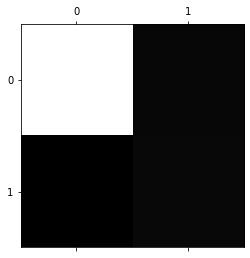

In [47]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [48]:
from sklearn.metrics import f1_score
f1_score = f1_score(ca_predictions1, ca_census_data_y_list)
f1_score

0.6823529411764707

In [49]:
from sklearn.metrics import precision_score
precision = precision_score(ca_predictions1, ca_census_data_y_list)
precision

0.5178571428571429

In [50]:
from sklearn.metrics import recall_score
recall_score = recall_score(ca_predictions1, ca_census_data_y_list)
recall_score

1.0

In [51]:
ca_census_data['test_two'].value_counts()

0    896
1     56
Name: test_two, dtype: int64

In [53]:
corr_matrix = ca_census_data.corr()
corr_matrix["test_two"].sort_values(ascending=False)

test_two                       1.000000
gentrified                     0.555294
change_percent_>25bachelors    0.361657
percent_change_home_value      0.358651
2018_home_value                0.193826
2018_percent_>25bachelors      0.184418
2010_female<25_bachelors       0.139232
2010_male<25_bachelors         0.102778
geoid                          0.094544
2018_male<25_bachelors         0.065689
2010_home_value                0.060384
2018_household_income          0.058923
2018_bachelors                 0.047668
2018_information               0.043291
2010_finance                   0.041901
2018_>25bachelors              0.039136
gentrify_elig                  0.023410
2018_finance                   0.014164
2010_arts_recreation_accom     0.004311
2018_no_nonh_others           -0.005010
2018_no_nonh_caucasians       -0.005125
2010_household_income         -0.007385
2010_no_amerinds_alskns       -0.011078
2010_no_nonh_caucasians       -0.020460
2010_no_nonh_asians           -0.021329


In [57]:
ca_census_data.to_csv('ca__test_one__test_two.csv', index=False)

In [58]:
corr_matrix["gentrified"].sort_values(ascending=False)

gentrified                     1.000000
test_two                       0.555294
gentrify_elig                  0.222938
percent_change_home_value      0.208123
change_percent_>25bachelors    0.179181
2010_no_nonh_blacks/aas        0.065555
2018_no_nonh_blacks/aas        0.061219
2018_male<25_bachelors         0.030455
2010_arts_recreation_accom     0.026715
2010_male<25_bachelors         0.021589
2018_no_nonh_others            0.015587
2018_arts_recreation_accom     0.007809
2018_percent_>25bachelors      0.003948
2018_no_amerinds_alskns        0.003449
2010_no_nonh_others           -0.008687
2010_no_nonh_asians           -0.010212
2018_no_nonh_asians           -0.016605
2018_armed_forces             -0.023415
2010_no_amerinds_alskns       -0.026809
2018_no_nonh_hawaii_pacific   -0.027415
2018_information              -0.028104
2010_armed_forces             -0.031268
2018_female<25_bachelors      -0.033403
2010_no_nonh_hawaii_pacific   -0.033676
2010_female<25_bachelors      -0.039507


## Graphs

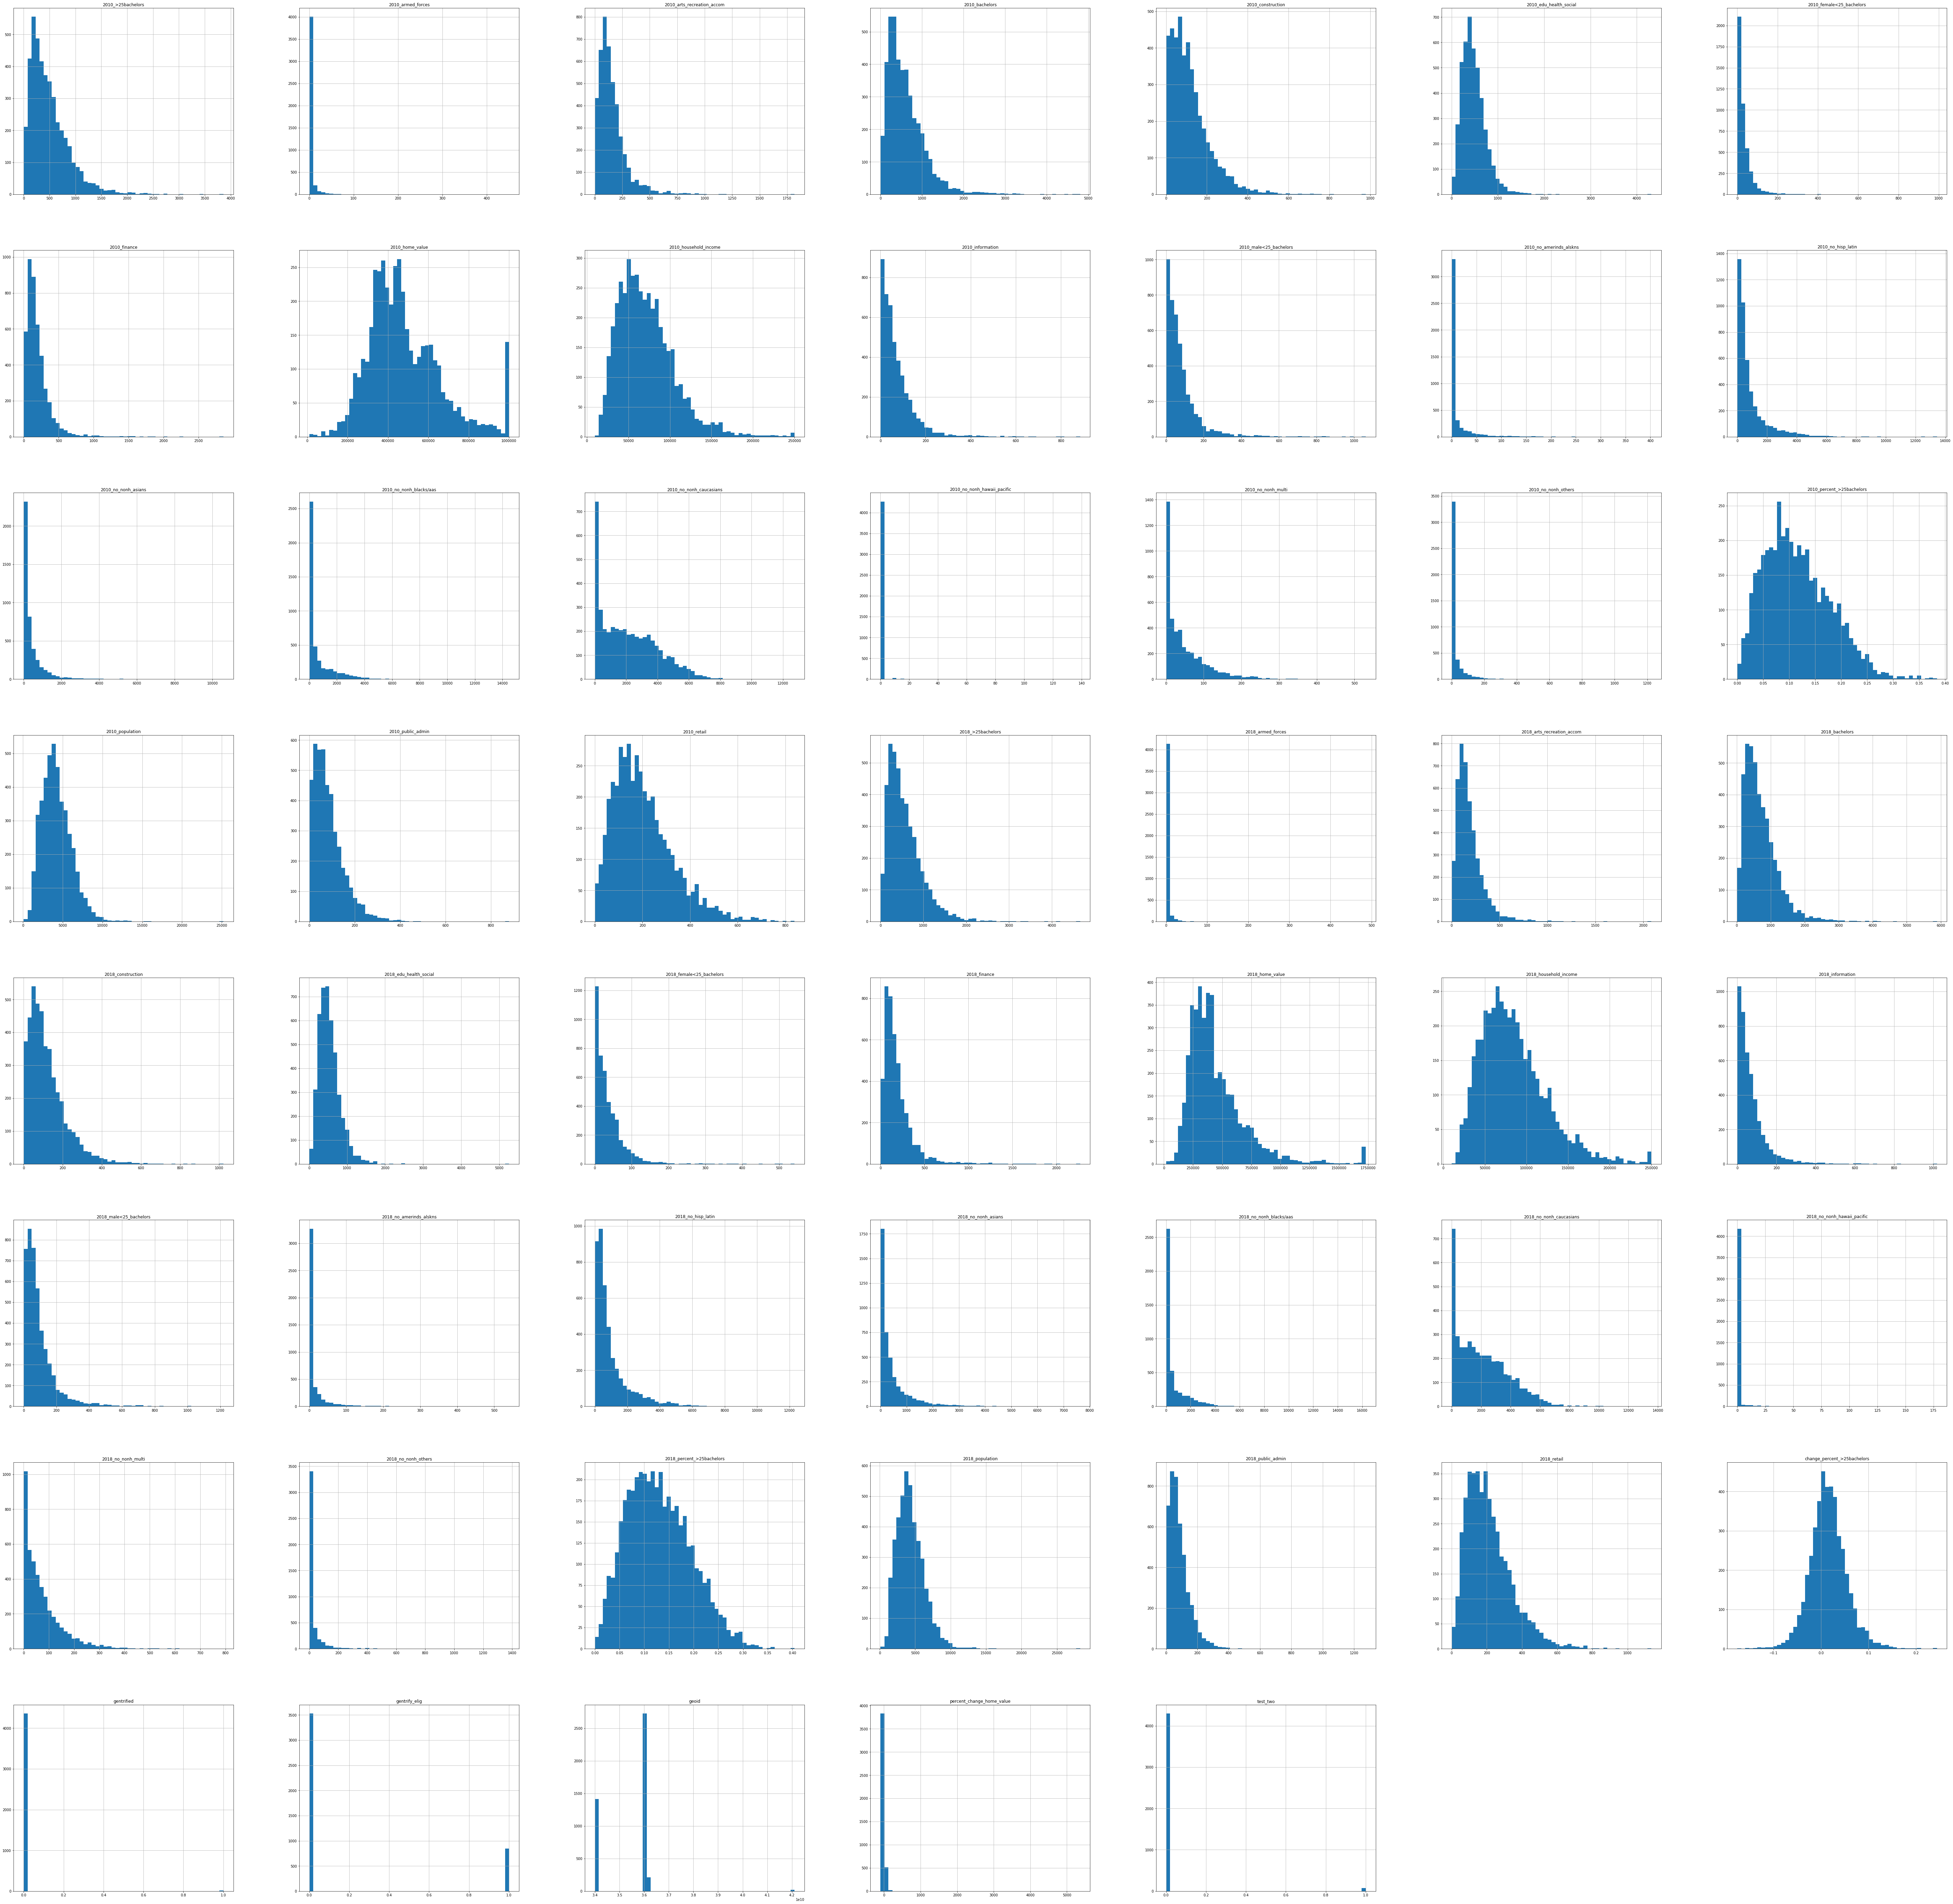

In [61]:
census_data.hist(bins=50, figsize=(100, 100))
plt.show()

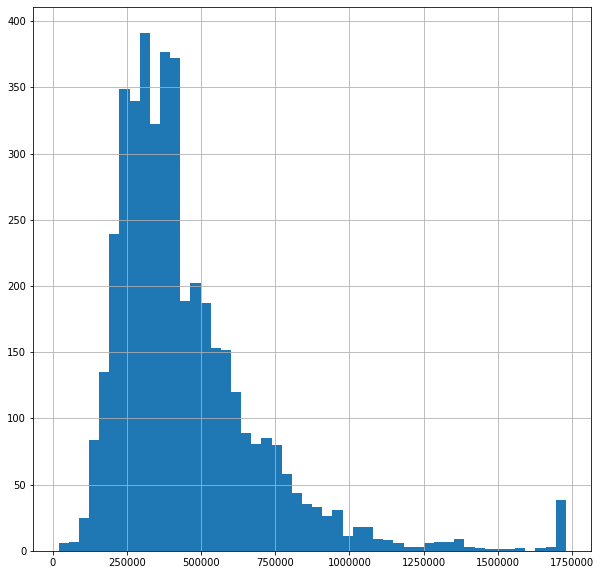

In [65]:
census_data['2018_home_value'].hist(bins=50, figsize=(10, 10))
plt.show()

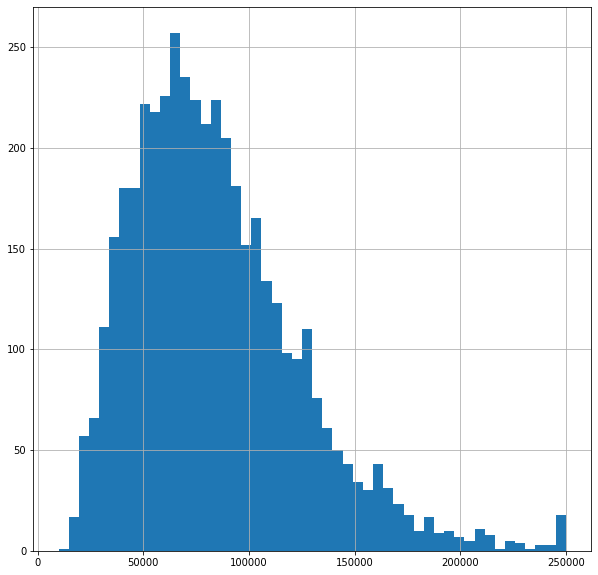

In [66]:
census_data['2018_household_income'].hist(bins=50, figsize=(10, 10))
plt.show()

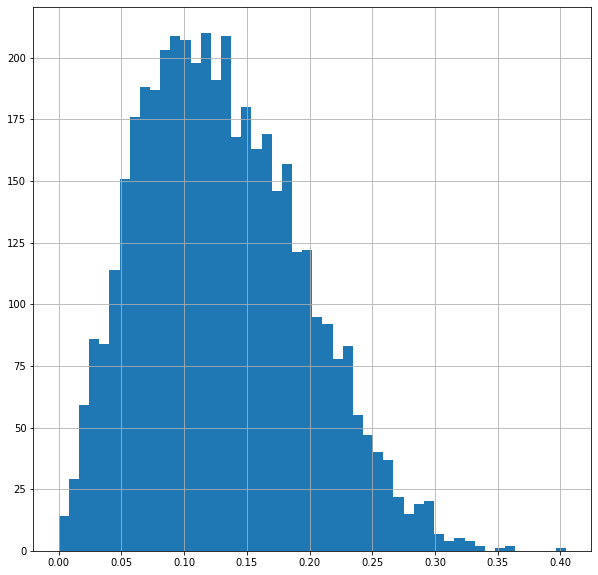

In [67]:
census_data['2018_percent_>25bachelors'].hist(bins=50, figsize=(10, 10))
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019AC3AE8A48>,
      dtype=object)

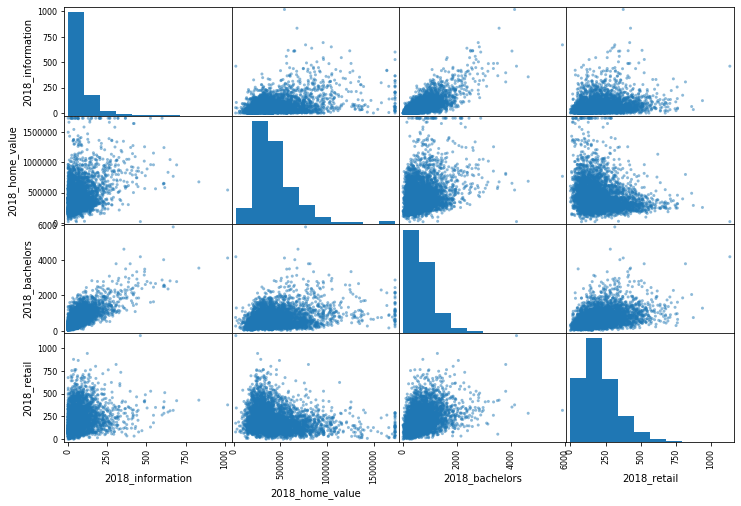

In [73]:
from pandas.plotting import scatter_matrix

attributes = ["2018_information", "2018_home_value", "2018_bachelors",
              "2018_retail"]
scatter_matrix(census_data[attributes], figsize=(12, 8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019AC3ECDC08>,
      dtype=object)

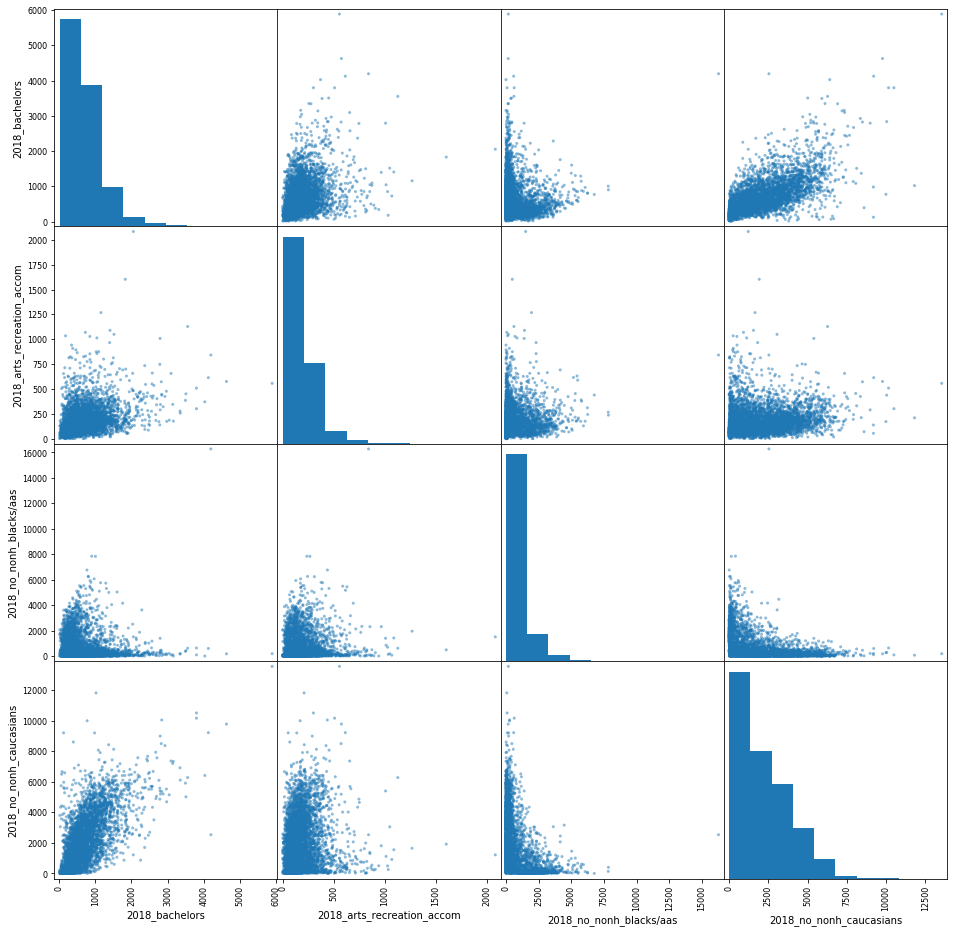

In [80]:
attributes = ["2018_bachelors", "2018_arts_recreation_accom", "2018_no_nonh_blacks/aas",
              "2018_no_nonh_caucasians"]
scatter_matrix(census_data[attributes], figsize=(16, 16))